In [28]:
import sys
sys.path.append("../../src")

In [29]:
import numpy as np
import cv2
import pandas as pd
from glob import glob
import torch.nn as nn
import json
from torch.utils.data import Dataset, DataLoader
from torchmetrics import AveragePrecision
import torch
import torchvision
import os
import torch.nn.functional as F
import time
import base64
import typing as t
import zlib
from pycocotools import _mask as coco_mask
import torchvision.transforms as T
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from models.utils import load_yaml

In [30]:
BASE_DIR = "D:/Machine_Learning/hubmap-hacking-the-human-vasculature/" 
MODEL_SAVE_PATH = os.path.join(BASE_DIR, "models/unet/version_1")
CONFIG_PATH = os.path.join(BASE_DIR, "src/models/config/unet.yaml")
MODEL_PATH = os.path.join(BASE_DIR, "models/unet/version_1/model-f0-val_dice=0.6518.ckpt")
test_directory = os.path.join(BASE_DIR, "data/test")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(MODEL_SAVE_PATH)
print(CONFIG_PATH)
config = load_yaml(CONFIG_PATH)

test_files = os.listdir(test_directory)
test_paths = [os.path.join(test_directory, file) for file in test_files]

D:/Machine_Learning/hubmap-hacking-the-human-vasculature/models/unet/version_1
D:/Machine_Learning/hubmap-hacking-the-human-vasculature/src/models/config/unet.yaml


In [91]:
class HUBMAPDataset(torch.utils.data.Dataset):
    def __init__(self, test_files, image_size=512):
        
        self.test_files = test_files
        self.normalize_image = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        self.image_size = image_size
        if image_size != 512:
            self.resize_image = T.transforms.Resize(image_size)
    

    def __get_id(self, path: str) -> str:
        """Extracts image id from path"""
        parts = path.split("\\")
        file_name = parts[-1]
        identity = file_name.split(".")[0]
        return identity
    
    def __get_image(self, path: str) -> np.array:
        """Gets Image From Path"""
        image = cv2.imread(path)
        image = image/255
        return torch.tensor(np.reshape(image, (512, 512, 3))).to(torch.float32).permute(2, 0, 1)
    
    def __getitem__(self, index):
        img_path = self.test_files[index]
        img = self.__get_image(img_path)
        img_id = self.__get_id(img_path)

        if self.image_size != 512:
            img = self.resize_image(img)
        
        img = self.normalize_image(img)
        
        return img.float(), img_id
    
    def __len__(self):
        return len(self.test_files)

In [92]:
ds = HUBMAPDataset(test_files=test_paths)
test_dl = DataLoader(ds, batch_size=16)

In [93]:
class TestTimeModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = smp.Unet(encoder_name="timm-resnest26d",
                              encoder_weights=None,
                              in_channels=3,
                              classes=1,
                              activation=None,
                              )

    def forward(self, batch):
        return self.model(batch)

In [94]:
image = test_dl

In [95]:
model = TestTimeModule().load_from_checkpoint(MODEL_PATH, config=config["model"])
model.to(device)
model.eval()

all_predictions = []
all_ids = []
all_images = []

with torch.no_grad():
    for i, (images, labels) in enumerate(test_dl):
        images = images.to(device)
        ids = labels

        predictions = model(images)
        sigmoid_predictions = torch.sigmoid(predictions)

        all_predictions.extend(sigmoid_predictions.cpu().numpy())
        all_ids.append(ids)

all_predictions = np.transpose(np.array(all_predictions), (0, 2, 3, 1))

72e40acccadf


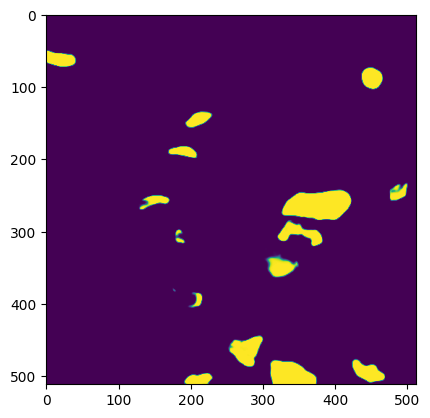

In [96]:
import matplotlib.pyplot as plt

print(all_ids[0][0])
plt.imshow(all_predictions[0])

In [97]:
def get_watershed(prediction, plot=False):
    normalized_prediction = cv2.normalize(prediction, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC3)
    ret, thresh = cv2.threshold(normalized_prediction, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 4)
    
    sure_bg = cv2.dilate(opening,kernel,iterations=3)
    
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.15*dist_transform.max(),255,0)
    
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    
    ret3, markers = cv2.connectedComponents(sure_fg)
    
    markers_norm = np.int32(markers + 10)
    markers_norm[unknown == 255] = 0
    
    prediction_rgb = cv2.cvtColor(prediction.astype(np.float32), cv2.COLOR_GRAY2BGR)
    image_cv = np.uint8(prediction_rgb)

    markers = cv2.watershed(image_cv, markers_norm)
    
    if plot:
        fig, axs = plt.subplots(6, 1, figsize=(6, 6 * 6))
        
        axs[0].imshow(thresh, cmap='gray')
        axs[0].set_title("Thresholded Prediction")
        
        axs[1].imshow(opening, cmap='gray')
        axs[1].set_title('Prediction after removing noise')
            
        axs[2].imshow(sure_bg, cmap='gray')
        axs[2].set_title('Sure Background')
        
        axs[3].imshow(sure_fg, cmap='gray')
        axs[3].set_title('Sure Foreground')
        
        axs[4].imshow(unknown, cmap='gray')
        axs[4].set_title('Unknown Region')
        
        axs[5].imshow(markers, cmap='gray')
        axs[5].set_title('Watershed image (instantiated image)')
        
        plt.show()
    return markers

def get_binary_masks(markers, background_label=10, marker_label=-1):
    """
    takes watershed markers and 
    """
    unique_labels = np.unique(markers)
    
    if background_label in unique_labels:
        unique_labels = unique_labels[unique_labels != background_label]
    if marker_label in unique_labels:
        unique_labels = unique_labels[unique_labels != marker_label]

    binary_masks = []

    for label in unique_labels:
        mask = np.where(markers == label, 1, 0).astype(np.uint8)
        kernel = np.ones((3, 3), np.uint8)
        mask = cv2.dilate(mask, kernel, iterations=4)
        binary_masks.append(mask)
        
    return binary_masks

def plot_binary_masks(prediction):
    markers = get_watershed(prediction)
    binary_masks = get_binary_masks(markers)

    fig, axs = plt.subplots(len(binary_masks), 1, figsize=(6,len(binary_masks) * 6))
    for i, mask in enumerate(binary_masks):
        axs[i].imshow(mask, cmap='gray')
        axs[i].set_title(f"Instance Segmentation {i + 1}")
        
def encode_binary_mask(mask: np.ndarray) -> str:
    # Check input mask
    if mask.dtype != np.bool_:
        raise ValueError(
            "encode_binary_mask expects a binary mask, received dtype == %s" %
            mask.dtype)

    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
        raise ValueError(
            "encode_binary_mask expects a 2d mask, received shape == %s" %
            mask.shape)

    # convert input mask to expected COCO API input --
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)

    # RLE encode mask --
    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

    # compress and base64 encoding --
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str

def encode_all_masks(binary_masks):
    encoded_masks = []
    for mask in binary_masks:
        encoded_mask = encode_binary_mask(mask.astype(np.bool_))
        encoded_masks.append(encoded_mask.decode('utf-8'))
    prefixed_masks = ['0 1.0 ' + mask for mask in encoded_masks]
    encoded_preds = ' '.join(prefixed_masks)
    return encoded_preds

def create_submission(all_predictions, all_ids):
    predictions = []
    image_ids = []
    for i, prediction in enumerate(all_predictions):
        markers = get_watershed(prediction, plot=False)
        binary_masks = get_binary_masks(markers)
        encoded_preds = encode_all_masks(binary_masks)
        image_ids.append(all_ids[i][0])     
        predictions.append(encoded_preds)

    df = pd.DataFrame({'id': image_ids, 'height': 512, 'width':512 ,'prediction_string': predictions})

    return df

In [99]:
df = create_submission(all_predictions, all_ids)
df.to_csv('submission.csv', index=False)
df.head()

,id,height,width,prediction_string
0,72e40acccadf,512,512,0 1.0 eNpLNEwziLI3MDD0NzCAkQaGBv5IFJxGAVClBoZ+...
